$\DeclareMathOperator{\trace}{tr}$

# Task 4 

# Libraries used

In [16]:
import numpy as np
from numpy import kron
from qiskit import *

## First moves

This task involves one of the most significant near term quantum algorithm: **Variational Quantum Eigensolver** (VQE). The issue at stake is to calculate the lowest eigenvalues of the following matrix:

$$ P = \begin{pmatrix}
0 & 0 & 0 & 0\\
0 & -1 & 1 & 0\\
0 & 1 & -1 & 0\\
0 & 0 & 0 & 0
\end{pmatrix}
$$

Let outline first the steps we will go through in order to solve this task.

1. Calculating the Hamiltonian decomposition
2. Stating the Ansatz
3. Composing the quantum circuit:
    * Prepare the quantum state
    * Expectation measurements
4. Executing the circuit

We will now continue covering all the topics above. 



## Calculating the Hamiltonian decomposition

*This section is based entirely on the article published by Michael Goerz, check it [here](https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html).*

We can perform the following operation to obtain an Hermitian matrix from an arbitrary given matrix:

$$
H = P^{\dagger} P
$$ 

In this case our original matrix was indeed hermitian. But, for the sake of following a common strategy we can perform the operation to obtain $H$:


In [17]:
P = np.matrix([[0,0,0,0], [0,-1,1,0], [0,1,-1,0], [0,0,0,0]])

H = P.getH() * P

H

matrix([[ 0,  0,  0,  0],
        [ 0,  2, -2,  0],
        [ 0, -2,  2,  0],
        [ 0,  0,  0,  0]])


We can decompose now the matrix (assuming it is an Hamiltonian) into a linear combination of the constituent parts of a basis of the 4x4 Hermitian matrices. The basis we shall consider is not other but the one generated by the Kronecker product of the Pauli Matrices and the Identity. We will now list all the 2x2 matrices involved which will generate our 4x4 Hermitian matrices basis:

$$
\sigma_{0} = Id = \begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix} $$ 

$$
\sigma_{1} = \sigma_{X} = \begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix} $$ 

$$\sigma_{2} = \sigma_{Y} = \begin{pmatrix}
0 & -i\\
i & 0
\end{pmatrix} $$ 

$$
\sigma_{3} = \sigma_{Z} = \begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
$$

Then, the basis will just be:

$$  
\mathcal{B} = \{ \sigma_{i} \otimes \sigma_{j} : 0 \leq i,j \leq 3 \}
$$

A decomposition of an arbitrary 4x4 matrix $F$ in terms of elements of $\mathcal{B}$ could be easily calculated as the following expression<sup>1</sup> shows:
$$ 
F = \sum_{i,j=1,x,y,z} a_{i,j} \left( \sigma_i \otimes \sigma_j \right),
\quad
a_{i,j} = \frac{1}{4} \trace \left[\left( \sigma_i \otimes \sigma_j \right) F \right]
$$

In [18]:
def product_HilbertSchmidt(A, B):
    """Hilbert-Schmidt-Product of two matrices A and B"""
    return (np.dot(A.conjugate().transpose(), B)).trace()


def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(F):
    """Decompose Hermitian 4x4 matrix F into Pauli matrices"""
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * product_HilbertSchmidt(kron(S[i], S[j]), F)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (c2s(a_ij), label))

In [19]:
decompose(H)

1	*	( I \otimes I )
-1	*	( sigma_x \otimes sigma_x )
-1	*	( sigma_y \otimes sigma_y )
-1	*	( sigma_z \otimes sigma_z )


This means that the following holds:

$$ 
H = \begin{pmatrix}
0 & 0 & 0 & 0\\
0 & -2 & 2 & 0\\
0 & 2 & -2 & 0\\
0 & 0 & 0 & 0
\end{pmatrix} =  Id \otimes Id - X \otimes X - Y \otimes Y - Z \otimes Z
$$

Thanks to the linear behaviour we can perform the following operations in order to calculate the expected value of the Hamiltonian:

$$ \left\langle H \right\rangle =  \left\langle \psi | H | \psi \right\rangle = \left\langle \psi | Id \otimes Id | \psi \right\rangle - \left\langle \psi | X \otimes X | \psi \right\rangle - \left\langle \psi | Y \otimes Y | \psi \right\rangle - \left\langle\psi | Z \otimes Z | \psi \right\rangle $$


Also, it is known that the eigenvector $\left| \psi_g \right\rangle$ that minimizes the expectation value $\left\langle H \right\rangle$ corresponds to the eigenvector of $H$ that has the smallest eigenvalue<sup>2</sup>. We will try with different states and select the one which performs the best after the measurement. For this purpose, an ansatz will be used to generate these vectors states. We can now proceed to the next step.

<sup>1</sup> The coefficient $1/4$ is a consequence of the fact that Pauli-matrices and the identity are not normalized as: $ \lVert\sigma_i\rVert = \sqrt{\trace\left[ \sigma_i^\dagger \sigma_i \right]} = \sqrt{2}$.

<sup>2</sup> This statement was retrieved from a [tutorial by David Khach](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb) who took it from a [paper published by nature](https://www.nature.com/articles/ncomms5213?origin=ppub). 


## Stating an Ansatz

The process of coming up with an ansatz is not trivial. Indeed, sometimes people just proceed with a trial and error method in order to calculate a valid ansatz. As the purpose of this task is merely to prove our skills to program and solve a given task, we will not go into the details of estimating the ansatz but just use the one provided:

$$ 
 (Id \otimes X)  CX  (RZ \otimes Id) (H \otimes Id)
$$

where RZ = RZ($\theta$) is a rotation which depends upon the angle $\theta$ we will have to calculate.


## Composing the quantum circuit

### Prepare the quantum state

We recall the ansatz we are using to prepare the quantum state:

$$ 
 (Id \otimes X)  CX  (RZ \otimes Id) (H \otimes Id)
$$

Therefore, we could build a function that will add these operations (we must have to take into account that the operator $RZ$ depends on the value of the parameter $\theta$ which represents the angle of rotation):


In [20]:
def quantum_state_preparation(circuit, theta):
    """
    Prepares the vector state 
    :param circuit: a quantum circuit with two qubits
    :param theta: the angle of rotation for the ansatz
    :return: quantum circuit.
    """
    qubits = circuit.qregs[0] 

    # Id (x) X
    circuit.iden(qubits[0])
    circuit.x(qubits[1])
    # CX
    circuit.cx(qubits[0],qubits[1])
    # RZ (x) Id
    circuit.rz(theta, qubits[0])
    circuit.iden(qubits[1])
    # H (x) Id
    circuit.h(qubits[0])
    circuit.iden(qubits[1])
    
    return circuit

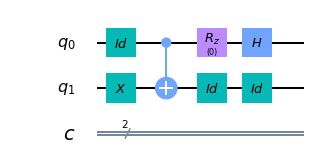

In [21]:
# Circuit representation of the section 
quantum_state_preparation(QuantumCircuit(2,2), 0).draw(output='mpl')

### Expectation measurements

We know from this formula: $ \left\langle H \right\rangle =  \left\langle \psi | H | \psi \right\rangle = \left\langle \psi | Id \otimes Id | \psi \right\rangle - \left\langle \psi | X \otimes X | \psi \right\rangle - \left\langle \psi | Y \otimes Y | \psi \right\rangle - \left\langle\psi | Z \otimes Z | \psi \right\rangle $ that we can just perform separate measurements on each term and classicaly add the expected values measured. 

We will start with the first term which can be easily calculated as:

$$ \left\langle \psi \right| Id \otimes Id \left| \psi \right\rangle = \left\langle \psi \right| \left| \psi \right\rangle = 1$$

The rest of the terms can be calculated by performing measurements on both qubits along the axis indicated by the operations themselves.


In [22]:
def apply_measurement(circuit, measurement_type):
    """
    Applies a measurement of the type indicated
    :param circuit: a quantum circuit with two qubits
    :param measurement_type: measurement type. E.g. 'Z' stands for Z measurement.
    :return: quantum circuit.
    """
    bits = circuit.cregs[0] 
    qubits = circuit.qregs[0] 
    
    if measurement_type == 'Z':
        pass # No rotation needed, default measurement on axis z
    elif measurement_type == 'X':
        circuit.u2(0, np.pi, qubits[0])
        circuit.u2(0, np.pi, qubits[1])
    elif measurement_type == 'Y':
        circuit.u2(0, np.pi/2, qubits[0])
        circuit.u2(0, np.pi/2, qubits[1])
    # else: Can't reach
    #    raise ValueError('Not valid input for measurement: input should be "X" or "Y" or "Z"')
        

    return circuit

### Creating the quantum modules


In [23]:
def quantum_module(theta, measurement_type):
    if measurement_type == 'I':
        return 1
    elif not (measurement_type in ['Z', 'X', 'Y']):
        ValueError('Not valid input for measurement: input should be "I" or "X" or "Z" or "Y"')
    
    circuit = QuantumCircuit(2,2)
    
    circuit = quantum_state_preparation(circuit, theta)
    
    circuit = apply_measurement(circuit, measurement_type)
    
    circuit.measure([0,1],[0,1])
    
    shots = 1000
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    positive_eigenvalue = 0
    positive_eigenvalue += counts.get("00",0)
    positive_eigenvalue += counts.get("11",0)
    
    negative_eigenvalue = 0
    negative_eigenvalue += counts.get("01",0)
    negative_eigenvalue += counts.get("10",0)
    
    expectation_value = (positive_eigenvalue - negative_eigenvalue) / shots
    
    return expectation_value

## Executing the circuit



In [24]:
energy_estimates = []
term_1_list = []
term_2_list = []
term_3_list = []

theta_values = np.linspace(0, 2*np.pi, 100)

for theta in theta_values:
    
    # Measure for X 
    quantum_module_I = quantum_module(theta, 'I')
    quantum_module_X = quantum_module(theta, 'X')
    quantum_module_Y = quantum_module(theta, 'Y')
    quantum_module_Z = quantum_module(theta, 'Z')
    
    aggregate_estimation = quantum_module_I - quantum_module_X - quantum_module_Y - quantum_module_Z
    
    term_1_list.append(quantum_module_X)
    term_2_list.append(quantum_module_Y)
    term_3_list.append(quantum_module_Z)
    energy_estimates.append(aggregate_estimation)
    

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
def plot_values(x, y, title=None):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(tck.FuncFormatter(
           lambda val,pos: '{:.2f}$\pi$'.format(val/np.pi) if val !=0 else '0'
        ))
    ax.xaxis.set_major_locator(tck.MultipleLocator(base=np.pi/4))
    ax.plot(x, y)
    if title is not None:
        ax.set_title(title)
    

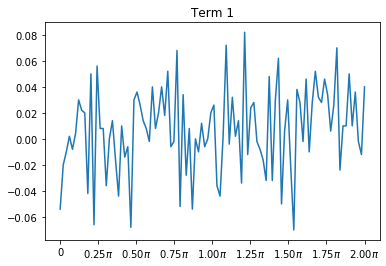

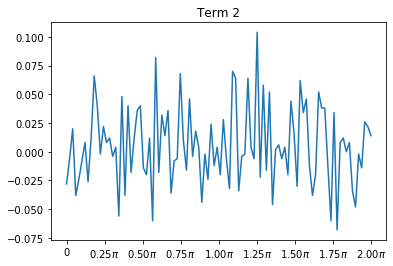

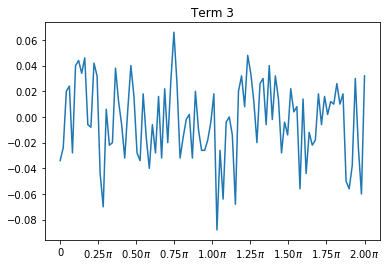

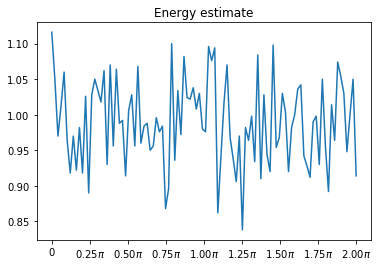

In [26]:
plot_values(theta_values, term_1_list, "Term 1")
plot_values(theta_values, term_2_list, "Term 2")
plot_values(theta_values, term_3_list, "Term 3")
plot_values(theta_values, energy_estimates, "Energy estimate")

## References

* https://qiskit.org/textbook/ch-applications/vqe-molecules.html